# Intro
- Goal
- Hypothesis
- Data cycle
- Methods we'll use
- Significance

In [142]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Add prose about each library that is used

In [143]:
# Import CSV to pandas dataframe
df = pd.read_csv("data.csv")
df.head()

# Add prose about how we retreived the data and its source

,Bene_Geo_Lvl,Bene_Geo_Desc,Bene_Geo_Cd,Bene_Age_Lvl,Bene_Demo_Lvl,Bene_Demo_Desc,Bene_Cond,Prvlnc,Tot_Mdcr_Stdzd_Pymt_PC,Tot_Mdcr_Pymt_PC,Hosp_Readmsn_Rate,ER_Visits_Per_1000_Benes
0,State,Alabama,1.0,All,All,All,Alcohol Abuse,0.0188,25102.3405,23348.6039,0.2413,2184.7557
1,State,Alabama,1.0,65+,Dual Status,Medicare Only,Alcohol Abuse,0.0118,NaN,NaN,NaN,NaN
2,State,Alabama,1.0,<65,Dual Status,Medicare Only,Alcohol Abuse,0.0320,NaN,NaN,NaN,NaN
3,State,Alabama,1.0,All,Dual Status,Medicare Only,Alcohol Abuse,0.0147,NaN,NaN,NaN,NaN
4,State,Alabama,1.0,65+,Dual Status,Medicare and Medicaid,Alcohol Abuse,0.0238,NaN,NaN,NaN,NaN


In [144]:
# Cleaning the data

# Deleting unneeded columns
df.drop(columns = 'Bene_Geo_Cd', inplace = True)

# Renaming columns
df = df.set_axis(['Geo_Lvl', 'State', 'Age_Lvl', 'Demographic', 'Demographic_Desc', 
                     'Condition', 'Prevalence', 'Medicare_Payment_Standardized', 
                     'Medicare_Payment', 'Hospital_Readmission_Rate', 'ER_Rate_Per_1000'], 
                     axis = 1)

# Deleting rows at end with too much missing data
df.drop(df.tail(21).index, inplace = True)

# Delete county-specific and national enteries
df = df.loc[df['Geo_Lvl'] == 'State']

df

,Geo_Lvl,State,Age_Lvl,Demographic,Demographic_Desc,Condition,Prevalence,Medicare_Payment_Standardized,Medicare_Payment,Hospital_Readmission_Rate,ER_Rate_Per_1000
0,State,Alabama,All,All,All,Alcohol Abuse,0.0188,25102.340500,23348.603900,0.2413,2184.7557
1,State,Alabama,65+,Dual Status,Medicare Only,Alcohol Abuse,0.0118,NaN,NaN,NaN,NaN
2,State,Alabama,<65,Dual Status,Medicare Only,Alcohol Abuse,0.0320,NaN,NaN,NaN,NaN
3,State,Alabama,All,Dual Status,Medicare Only,Alcohol Abuse,0.0147,NaN,NaN,NaN,NaN
4,State,Alabama,65+,Dual Status,Medicare and Medicaid,Alcohol Abuse,0.0238,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
236098,State,Wyoming,65+,All,All,Hypertension,0.4185,14091.718674,16051.028884,NaN,NaN
236099,State,Wyoming,65+,All,All,Ischemic Heart Disease,0.2113,16965.132331,19512.892238,NaN,NaN
236100,State,Wyoming,65+,All,All,Osteoporosis,0.0512,18563.682367,21084.682682,NaN,NaN
236101,State,Wyoming,65+,All,All,Schizophrenia and Other Psychotic Disorders,0.0067,21828.833222,24658.202736,NaN,NaN


In [145]:
# Bar graph of state vs per capita spending

df1 = df[["State", "Medicare_Payment"]]

df1 = df1.dropna(subset=['Medicare_Payment'])

df1 = df1.groupby(['State']).sum()

df1


,Medicare_Payment
State,
Alabama,1.264863e+06
Alaska,1.650902e+06
Arizona,1.474884e+06
Arkansas,1.268369e+06
California,1.912136e+06
Colorado,1.397672e+06
Connecticut,1.700346e+06
Delaware,1.499545e+06
District of Columbia,1.927823e+06


<Axes: xlabel='State'>

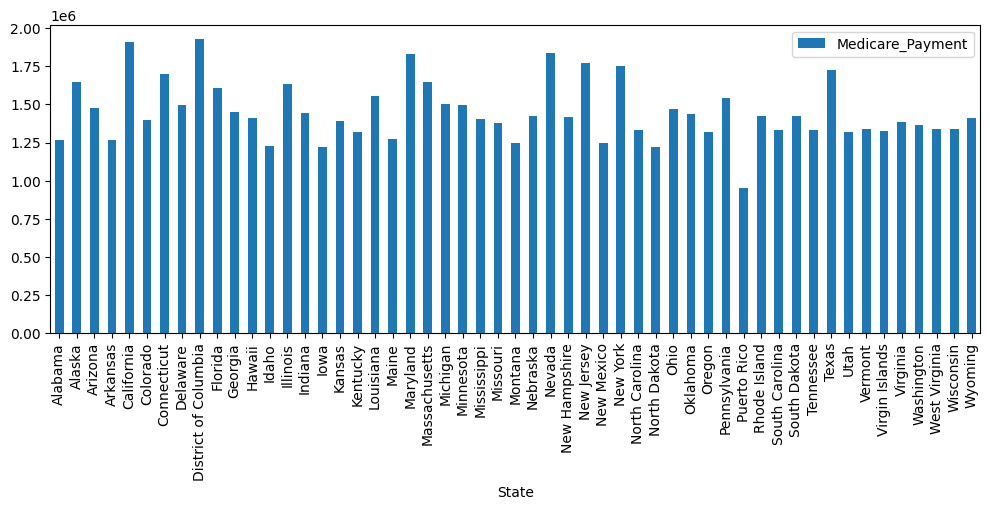

In [146]:
df1.plot.bar(figsize=(12, 4))

In [148]:
# Bar graph of disease vs per capita spending

df2 = df[["Condition", "Medicare_Payment"]]

df2 = df2.dropna(subset=['Medicare_Payment'])

df2 = df2.groupby(['Condition']).sum()

df2

,Medicare_Payment
Condition,
Alcohol Abuse,4.007717e+06
Alzheimer's Disease/Dementia,4.370870e+06
Arthritis,2.642109e+06
Asthma,3.492510e+06
Atrial Fibrillation,5.027974e+06
Autism Spectrum Disorders,1.718904e+06
COPD,4.274726e+06
Cancer,3.688560e+06
Chronic Kidney Disease,3.999802e+06


<Axes: xlabel='Condition'>

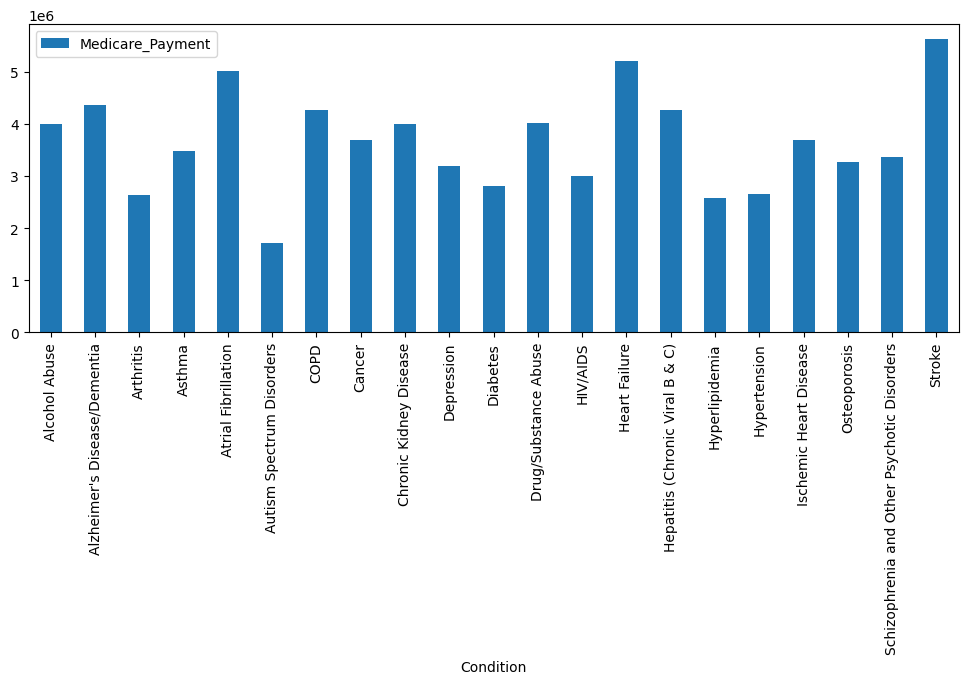

In [149]:
df2.plot.bar(figsize=(12, 4))

In [151]:
# Bar graph of state vs condition

df2 = df[["State", "Prevalence", "Medicare_Payment"]]

df2 = df2.dropna(subset=['Medicare_Payment'])

df2.drop(columns = 'Medicare_Payment', inplace = True)

df2 = df2.groupby(['State']).sum()

df2

,Prevalence
State,
Alabama,9.8964
Alaska,6.5883
Arizona,8.2265
Arkansas,8.9524
California,8.6566
Colorado,7.1760
Connecticut,9.4564
Delaware,9.8540
District of Columbia,8.9326


<Axes: xlabel='State'>

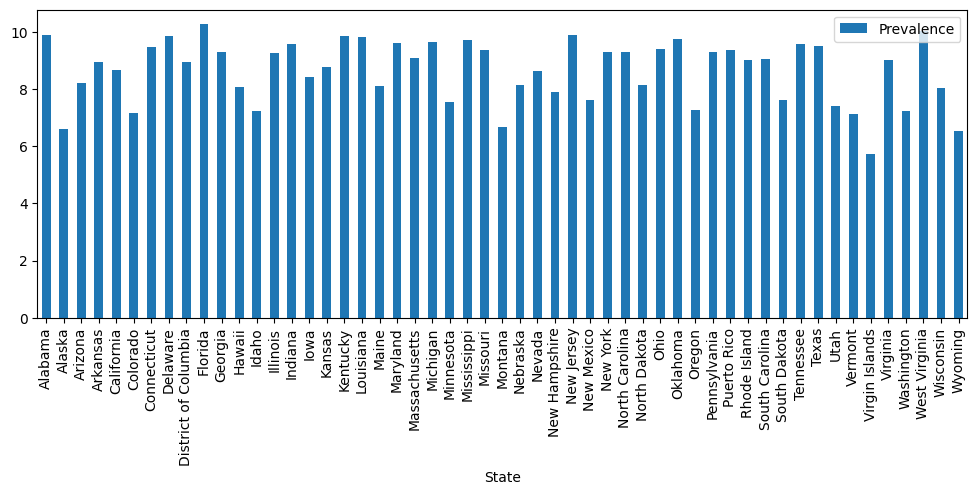

In [152]:
df2.plot.bar(figsize=(12, 4))